# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [465]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [466]:
from pandas.api.types import CategoricalDtype

from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import matplotlib.dates as mdates

import scipy.stats as stats

from lifelines import KaplanMeierFitter

## Analytic methods

If we know the parameters of the sampling distribution, we can compute confidence intervals and p-values analytically, which is computationally faster than resampling.

In [467]:
import scipy.stats

def EvalNormalCdfInverse(p, mu=0, sigma=1):
    return scipy.stats.norm.ppf(p, loc=mu, scale=sigma)

Here's the confidence interval for the estimated mean.

In [468]:
EvalNormalCdfInverse(0.05, mu=90, sigma=2.5)

85.88786593262132

In [469]:
EvalNormalCdfInverse(0.95, mu=90, sigma=2.5)

94.11213406737868

In [470]:
# Try getting the confidence interval making the object first
norm_rv = scipy.stats.norm(loc=90, scale=2.5)

In [471]:
# That works too
norm_rv.interval(.90)

(85.88786593262132, 94.11213406737868)

In [472]:
norm_rv.stats()

(array(90.), array(6.25))

In [473]:
# And just as a reminder try it by resampling too
import dataStatsAnalysis as dsa
import dataStatsPlotting as dsp

In [474]:
# First compute the sampling distribution, using a sample size of 9 which was the size used in the book example
sample_means = []
for i in range(1000):
    norm_resample = np.random.normal(loc=90, scale=7.5, size=9)
    sample_means.append(norm_resample.mean())
sample_means = np.array(sample_means)

In [475]:
reample_mean = sample_means.mean()
resample_std = sample_means.std()
reample_mean, resample_std

(89.93777934030234, 2.5507040386309585)

In [476]:
means_rv = dsa.DiscreteRv(sample_means)

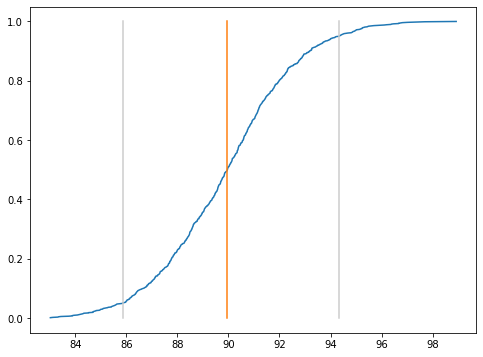

In [477]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)
ax.plot(means_rv.xk, means_rv.cdf(means_rv.xk))
ax.plot([means_rv.mean(), means_rv.mean()], [0, 1], color='C1')
ax.plot([means_rv.ppf(.05), means_rv.ppf(.05)], [0, 1], color='0.8')
ax.plot([means_rv.ppf(.95), means_rv.ppf(.95)], [0, 1], color='0.8')

In [478]:
means_rv.mean(), means_rv.interval(.9)

(89.93777934030234, (85.86745518643842, 94.32675119105866))

`normal.py` provides a `Normal` class that encapsulates what we know about arithmetic operations on normal distributions.

In [479]:
from normal import Normal

dist = Normal(90, 7.5**2)
dist

Normal(90, 56.25)

We can use it to compute the sampling distribution of the mean.

In [480]:
dist_xbar = dist.Sum(9) / 9
dist_xbar.sigma

2.5

In [481]:
# Check out what is happening here
dist.sigma

7.5

In [482]:
dist_xbar

Normal(90, 6.25)

In [483]:
dist.Sum(9)

Normal(810, 506.25)

In [484]:
# What the hell is going on here when dividing by 9?
# I think I got it finally: _div_ actually uses _mul_ inside it which includes the factor squared for the variance.
dist.Sum(9)/9

Normal(90, 6.25)

And then compute a confidence interval.

In [485]:
dist_xbar.Percentile(5), dist_xbar.Percentile(95)

(85.88786593262132, 94.11213406737868)

## Central Limit Theorem

If you add up independent variates from a distribution with finite mean and variance, the sum converges on a normal distribution.

The following function generates samples with difference sizes from an exponential distribution.

In [486]:
def MakeExpoSamples(beta=2.0, iters=1000):
    """Generates samples from an exponential distribution.

    beta: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

This function generates normal probability plots for samples with various sizes.

In [487]:
def NormalPlotSamples(samples, plot=1, ylabel=''):
    """Makes normal probability plots for samples.

    samples: list of samples
    label: string
    """
    for n, sample in samples:
        thinkplot.SubPlot(plot)
        thinkstats2.NormalProbabilityPlot(sample)

        thinkplot.Config(title='n=%d' % n,
                         legend=False,
                         xticks=[],
                         yticks=[],
                         xlabel='random normal variate',
                         ylabel=ylabel)
        plot += 1

The following plot shows how the sum of exponential variates converges to normal as sample size increases.

C:\Users\pthus\pythonProjects\dataAnalysisPractice\ThinkStats2\code\thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


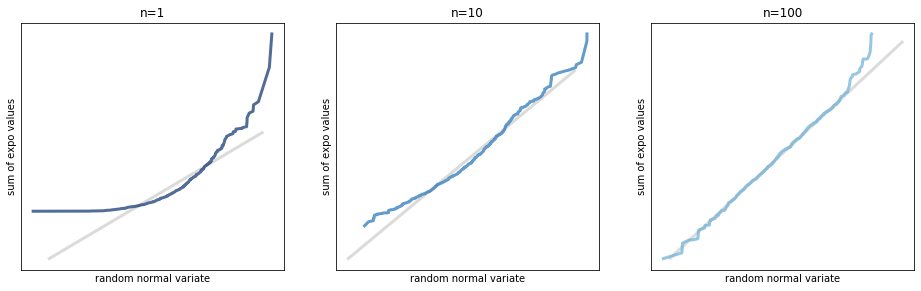

In [488]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeExpoSamples()
NormalPlotSamples(samples, plot=1,
                  ylabel='sum of expo values')

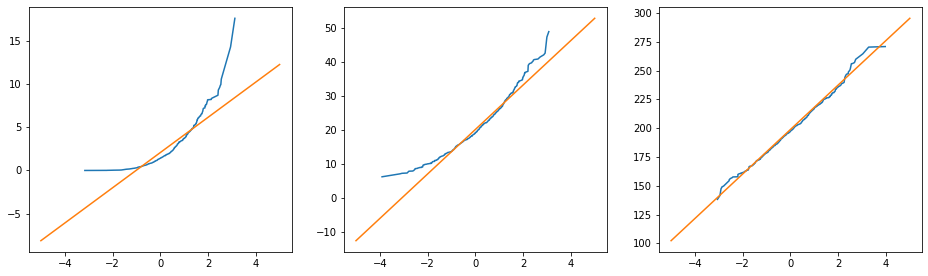

In [489]:
# Mine, I will just use the books function for creating the samples and use my own methods for plotting
fig,axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(16,4.5)

plot_num=0
for n, sample in samples:
    sample = np.array(sample)
    xs, ys = dsa.NormalProbabilityValues(sample)
    fit_xs, fit_ys = dsa.FitLine([-5,5], sample.mean(), sample.std())
    axes[plot_num].plot(xs, ys)
    axes[plot_num].plot(fit_xs, fit_ys)
    
    plot_num += 1

The lognormal distribution has higher variance, so it requires a larger sample size before it converges to normal.

In [490]:
def MakeLognormalSamples(mu=1.0, sigma=1.0, iters=1000):
    """Generates samples from a lognormal distribution.

    mu: parmeter
    sigma: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

C:\Users\pthus\pythonProjects\dataAnalysisPractice\ThinkStats2\code\thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


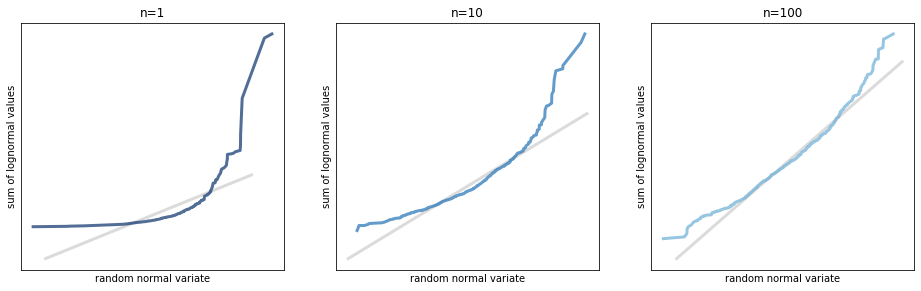

In [491]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeLognormalSamples()
NormalPlotSamples(samples, ylabel='sum of lognormal values')

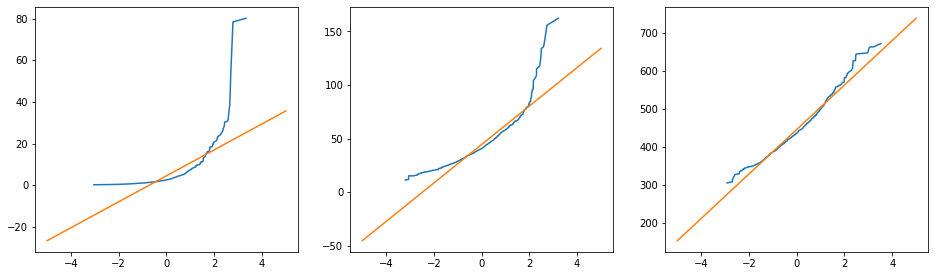

In [492]:
# Mine, I will just use the books function for creating the samples and use my own methods for plotting
fig,axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(16,4.5)

plot_num=0
for n, sample in samples:
    sample = np.array(sample)
    xs, ys = dsa.NormalProbabilityValues(sample)
    fit_xs, fit_ys = dsa.FitLine([-5,5], sample.mean(), sample.std())
    axes[plot_num].plot(xs, ys)
    axes[plot_num].plot(fit_xs, fit_ys)
    
    plot_num += 1

The Pareto distribution has infinite variance, and sometimes infinite mean, depending on the parameters.  It violates the requirements of the CLT and does not generally converge to normal.

In [493]:
def MakeParetoSamples(alpha=1.0, iters=1000):
    """Generates samples from a Pareto distribution.

    alpha: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []

    for n in [1, 10, 100]:
        sample = [np.sum(np.random.pareto(alpha, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

C:\Users\pthus\pythonProjects\dataAnalysisPractice\ThinkStats2\code\thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


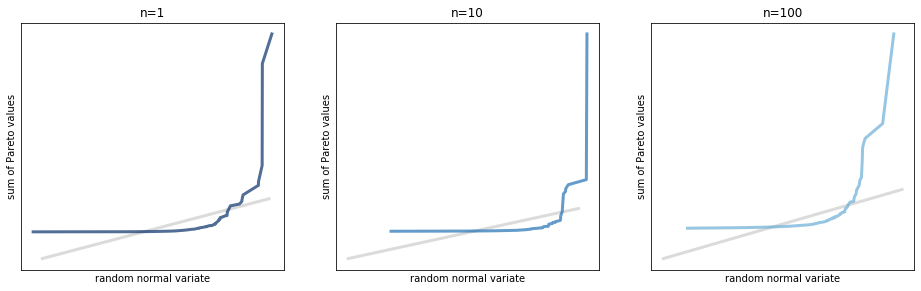

In [494]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeParetoSamples()
NormalPlotSamples(samples, ylabel='sum of Pareto values')

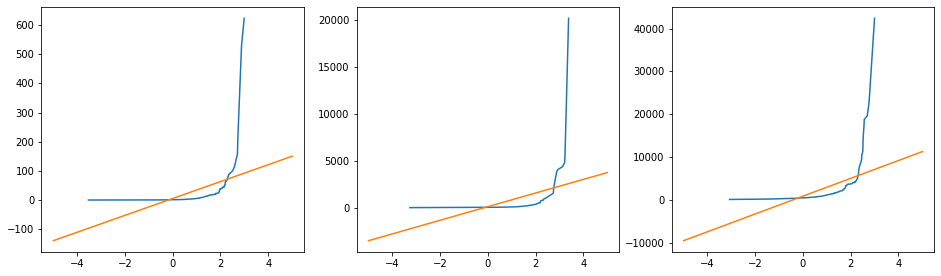

In [495]:
# Mine, I will just use the books function for creating the samples and use my own methods for plotting
fig,axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(16,4.5)

plot_num=0
for n, sample in samples:
    sample = np.array(sample)
    xs, ys = dsa.NormalProbabilityValues(sample)
    fit_xs, fit_ys = dsa.FitLine([-5,5], sample.mean(), sample.std())
    axes[plot_num].plot(xs, ys)
    axes[plot_num].plot(fit_xs, fit_ys)
    
    plot_num += 1

If the random variates are correlated, that also violates the CLT, so the sums don't generally converge.

To generate correlated values, we generate correlated normal values and then transform to whatever distribution we want.

In [496]:
def GenerateCorrelated(rho, n):
    """Generates a sequence of correlated values from a standard normal dist.
    
    rho: coefficient of correlation
    n: length of sequence

    returns: iterator
    """
    x = random.gauss(0, 1)
    yield x

    sigma = np.sqrt(1 - rho**2)
    for _ in range(n-1):
        x = random.gauss(x * rho, sigma)
        yield x

In [497]:
def GenerateExpoCorrelated(rho, n):
    """Generates a sequence of correlated values from an exponential dist.

    rho: coefficient of correlation
    n: length of sequence

    returns: NumPy array
    """
    normal = list(GenerateCorrelated(rho, n))
    uniform = scipy.stats.norm.cdf(normal)
    expo = scipy.stats.expon.ppf(uniform)
    return expo

In [498]:
def MakeCorrelatedSamples(rho=0.9, iters=1000):
    """Generates samples from a correlated exponential distribution.

    rho: correlation
    iters: number of samples to generate for each size

    returns: list of samples
    """    
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(GenerateExpoCorrelated(rho, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples


C:\Users\pthus\pythonProjects\dataAnalysisPractice\ThinkStats2\code\thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


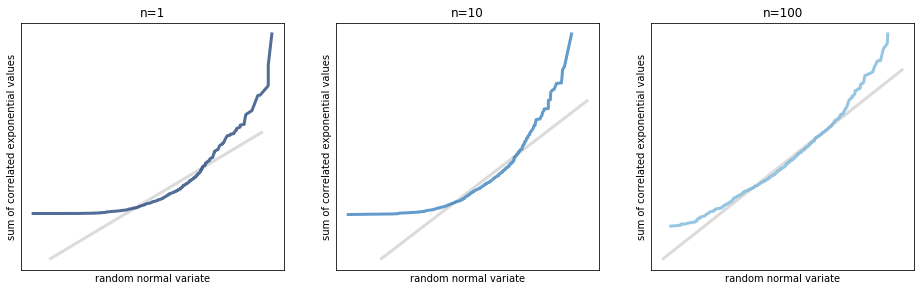

In [499]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeCorrelatedSamples()
NormalPlotSamples(samples, ylabel='sum of correlated exponential values')

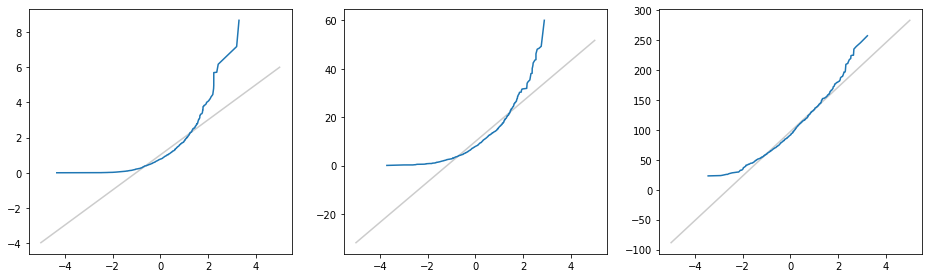

In [500]:
# Mine, I will just use the books function for creating the samples and use my own methods for plotting
fig,axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(16,4.5)

plot_num=0
for n, sample in samples:
    sample = np.array(sample)
    xs, ys = dsa.NormalProbabilityValues(sample)
    fit_xs, fit_ys = dsa.FitLine([-5,5], sample.mean(), sample.std())
    axes[plot_num].plot(fit_xs, fit_ys, color='0.8')
    axes[plot_num].plot(xs, ys)
    
    plot_num += 1

## Difference in means

Let's use analytic methods to compute a CI and p-value for an observed difference in means.

The distribution of pregnancy length is not normal, but it has finite mean and variance, so the sum (or mean) of a few thousand samples is very close to normal.

In [501]:
import first

live, firsts, others = first.MakeFrames()
delta = firsts.prglngth.mean() - others.prglngth.mean()
delta

0.07803726677754952

The following function computes the sampling distribution of the mean for a set of values and a given sample size.

In [502]:
def SamplingDistMean(data, n):
    """Computes the sampling distribution of the mean.

    data: sequence of values representing the population
    n: sample size

    returns: Normal object
    """
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

Here are the sampling distributions for the means of the two groups under the null hypothesis.

In [503]:
dist1 = SamplingDistMean(live.prglngth, len(firsts))
dist2 = SamplingDistMean(live.prglngth, len(others))

In [504]:
dist1

Normal(38.5606, 0.00165481)

In [505]:
dist2

Normal(38.5606, 0.00154227)

And the sampling distribution for the difference in means.

In [506]:
dist_diff = dist1 - dist2
dist_diff

Normal(0, 0.00319708)

Under the null hypothesis, here's the chance of exceeding the observed difference.

In [507]:
1 - dist_diff.Prob(delta)

0.08377070425543831

And the chance of falling below the negated difference.

In [508]:
dist_diff.Prob(-delta)

0.08377070425543826

The sum of these probabilities is the two-sided p-value.

In [509]:
# Try this using scipy, same as above two-sided result
stats.ttest_ind(firsts.prglngth, others.prglngth)

Ttest_indResult(statistic=1.3802152088125652, pvalue=0.16755412639415004)

In [510]:
# Try this using non-parametric methods
np.random.seed(10)
diff_means_dist = dsa.ResampleDiffMeans_H0(firsts.prglngth, others.prglngth, onesided=True)
diff_means_rv = dsa.DiscreteRv(diff_means_dist[1])

In [511]:
1-diff_means_rv.cdf(delta)

0.0919999999999993

In [512]:
diff_means_rv.cdf(-delta)

0.08200000000000006

In [513]:
# Two-sided p-value is the sum of the above
p_value = 1-diff_means_rv.cdf(delta) + diff_means_rv.cdf(-delta)
p_value

0.17399999999999938

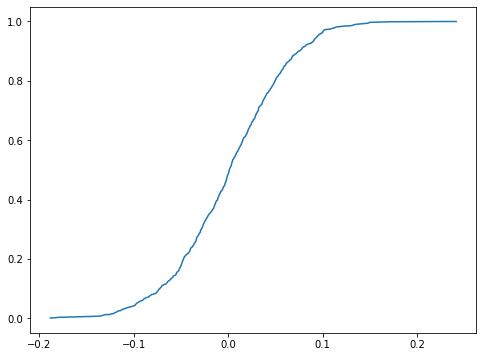

In [514]:
# Try plotting this distribution too: cdf
# This is what the plot looks like using onesided=True
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(diff_means_rv.xk, diff_means_rv.cdf(diff_means_rv.xk))

In [515]:
# Using onesided = False gives the same result as adding the two tails above
np.random.seed(10)
diff_means_dist = dsa.ResampleDiffMeans_H0(firsts.prglngth, others.prglngth, onesided=False)
diff_means_rv = dsa.DiscreteRv(diff_means_dist[1])

In [516]:
1-diff_means_rv.cdf(delta)

0.17399999999999938

In [517]:
# Try also using the distribution summary function I made in the analysis module
dsa.SummarizeEstimates(diff_means_dist[1])

(0.04546275588277032,
 0.03528198104876418,
 (0.0012038924067780954, 0.13079164444304325))

In [518]:
# Same p-vale obtained this way
dsa.PvalueFromEstimates(diff_means_dist[1], delta, tail='right')

0.17399999999999938

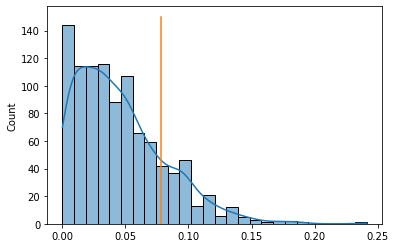

In [519]:
# This is what the distribution looks like if using onesided=False to create the sampling distribution
# It is shaped like this because onesided=False uses absolute value of the differences
g = sns.histplot(diff_means_dist[1],kde=True)
g.plot([delta, delta], [0, 150], color='C1') # The test statistic (delta)

(0, 0.25)

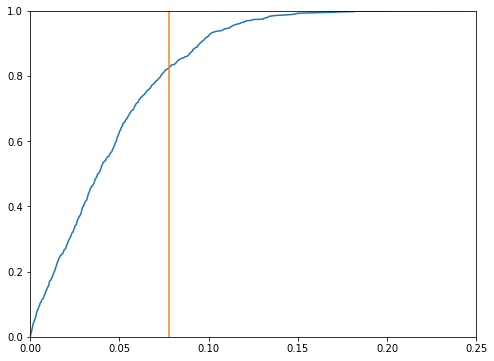

In [520]:
# And the cdf, again it is shaped like this because abs value was used in the calculation (onesided=False)
# This is consistent with a cdf plot in the book in section 9.3
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(diff_means_rv.xk, diff_means_rv.cdf(diff_means_rv.xk))
ax.plot([delta, delta], [0, 1], color='C1') # The test statistic (delta)
ax.set_ylim(0,1)
ax.set_xlim(0,0.25)

## Testing a correlation

Under the null hypothesis (that there is no correlation), the sampling distribution of the observed correlation (suitably transformed) is a "Student t" distribution.

In [521]:
def StudentCdf(n):
    """Computes the CDF correlations from uncorrelated variables.

    n: sample size

    returns: Cdf
    """
    ts = np.linspace(-3, 3, 101)
    ps = scipy.stats.t.cdf(ts, df=n-2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    return thinkstats2.Cdf(rs, ps)

The following is a `HypothesisTest` that uses permutation to estimate the sampling distribution of a correlation. 

In [522]:
import hypothesis

class CorrelationPermute(hypothesis.CorrelationPermute):
    """Tests correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        xs, ys = data
        return np.corrcoef(xs, ys)[0][1]

Now we can estimate the sampling distribution by permutation and compare it to the Student t distribution.

In [523]:
def ResampleCorrelations(live):
    """Tests the correlation between birth weight and mother's age.

    live: DataFrame for live births

    returns: sample size, observed correlation, CDF of resampled correlations
    """
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    return len(live2), ht.actual, ht.test_cdf

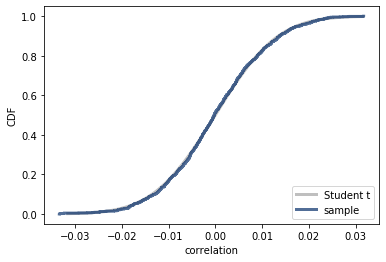

In [524]:
n, r, cdf = ResampleCorrelations(live)

model = StudentCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray',
               alpha=0.5, label='Student t')
thinkplot.Cdf(cdf, label='sample')

thinkplot.Config(xlabel='correlation',
                 ylabel='CDF',
                 legend=True, loc='lower right')

That confirms the analytic result.  Now we can use the CDF of the Student t distribution to compute a p-value.

In [525]:
t = r * np.sqrt((n-2) / (1-r**2))
p_value = 1 - scipy.stats.t.cdf(t, df=n-2)
print(r, p_value)

0.06883397035410904 2.861466619208386e-11


In [526]:
# I already redid this using resampling in the Chapter 9 notebook
# Using pearsonr in Scipy can get you the p-value as well but it is two-sided
# If needed can just cut it in half to get the same result as above
# Anyways I will redo this again here

In [527]:
# Using the author's code to get to the rs and ps for the parametric case
my_ts = np.linspace(-3, 3, 101)
my_ps = scipy.stats.t.cdf(my_ts, df=n-2)
my_rs = my_ts / np.sqrt(n - 2 + my_ts**2)

In [528]:
# Getting the data from the author's code
live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [529]:
# Creating the rv from resampling, using one-sided = True to remove the absolute value part of the calculation
result = dsa.ResampleCorrelation(live2.agepreg.values, live2.totalwgt_lb.values, onesided=True)

In [530]:
result

(0.0688339703541091,
 array([ 2.66930309e-03, -1.47235330e-02,  7.33844892e-04, -6.17235168e-03,
        -2.21013963e-02,  5.24480466e-04, -1.18964103e-03, -1.27875089e-02,
         3.71929071e-03, -1.35349889e-02, -1.46482951e-02, -1.82810615e-03,
        -1.24856556e-02,  1.65974223e-02, -2.44770256e-02,  1.23603525e-02,
         3.71112940e-03, -5.65774739e-03,  6.87282131e-04, -9.27750252e-03,
         9.79020025e-04, -8.61332008e-04,  2.92769326e-02, -4.21309041e-03,
         1.02087479e-02, -9.29174722e-03,  4.32252870e-03,  1.09908626e-02,
         2.62727857e-02,  1.19709619e-02,  5.49352114e-03,  1.68166899e-02,
        -8.66433928e-04,  2.09284797e-03, -7.37839440e-03,  9.59644671e-03,
        -1.90891456e-03, -2.71229506e-02,  4.07812284e-03,  1.06175602e-03,
        -1.10793073e-03,  1.39278843e-03,  3.80161112e-03,  5.64641076e-03,
         4.62877657e-03,  1.25004033e-02,  7.38190374e-03,  2.18069606e-02,
         1.42836262e-02,  5.16286895e-03, -5.95327857e-03,  1.54436

In [531]:
corr_rv = dsa.DiscreteRv(result[1])

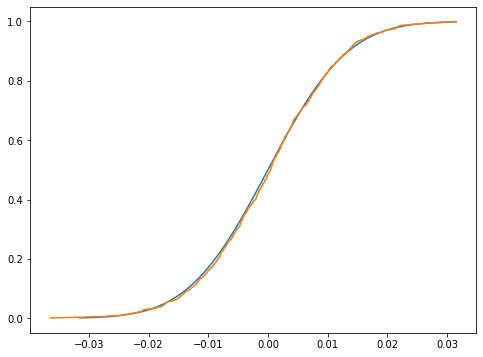

In [532]:
# In the parametric case creating the rv is really not necessary since the x and y values for plotting are already calculated

fig,ax = plt.subplots()
fig.set_size_inches(8,6)

# Plot parametric case
plt.plot(my_rs, my_ps)

# Plot non-parametric case
plt.plot(corr_rv.xk, corr_rv.cdf(corr_rv.xk))

In [533]:
# Parametric pvalue
stats.pearsonr(live2.agepreg.values, live2.totalwgt_lb.values)[1]

5.722947107252811e-11

In [534]:
# Non-parametric pvalue
dsa.PvalueFromEstimates(result[1], result[0])
# This is 0 because the actual is far beyond the results obtained through resampling

0.0

##  Chi-squared test

The reason the chi-squared statistic is useful is that we can compute its distribution under the null hypothesis analytically.

In [535]:
def ChiSquaredCdf(n):
    """Discrete approximation of the chi-squared CDF with df=n-1.

    n: sample size
    
    returns: Cdf
    """
    xs = np.linspace(0, 25, 101)
    ps = scipy.stats.chi2.cdf(xs, df=n-1)
    return thinkstats2.Cdf(xs, ps)

Again, we can confirm the analytic result by comparing values generated by simulation with the analytic distribution.

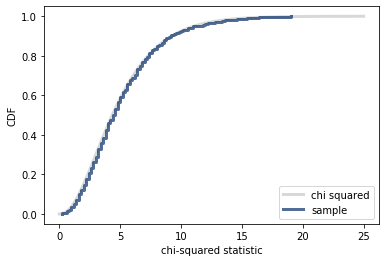

In [536]:
data = [8, 9, 19, 5, 8, 11]
dt = hypothesis.DiceChiTest(data)
p_value = dt.PValue(iters=1000)
n, chi2, cdf = len(data), dt.actual, dt.test_cdf

model = ChiSquaredCdf(n)
thinkplot.Plot(model.xs, model.ps, color='gray',
                   alpha=0.3, label='chi squared')
thinkplot.Cdf(cdf, label='sample')

thinkplot.Config(xlabel='chi-squared statistic',
                 ylabel='CDF',
                 loc='lower right')

And then we can use the analytic distribution to compute p-values.

In [537]:
p_value = 1 - scipy.stats.chi2.cdf(chi2, df=n-1)
print(chi2, p_value)

11.6 0.04069938850404997


In [538]:
# Mine
my_data = [8, 9, 19, 5, 8, 11]
expected = np.full(6, 10)
actual, chis = dsa.ResampleChisquared(my_data, expected)
chi_rv = dsa.DiscreteRv(chis)

In [539]:
my_xs = np.linspace(0, 25, 101)
my_ps = scipy.stats.chi2.cdf(my_xs, df=n-1)

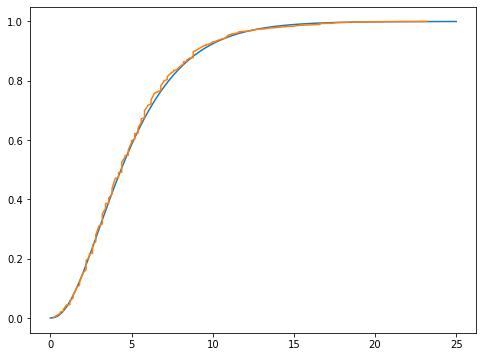

In [540]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

# Plot parametric case
plt.plot(my_xs, my_ps)

# Plot non-parametric case
plt.plot(chi_rv.xk, chi_rv.cdf(chi_rv.xk))

In [541]:
# Getting the p-value from the data (parametric)
stats.chisquare(my_data, expected)

Power_divergenceResult(statistic=11.6, pvalue=0.040699388504049985)

In [542]:
# Getting the p-value from the data (non-parametric)
dsa.PvalueFromEstimates(chis, actual)

0.03799999999999937

## Exercises

**Exercise:**    In Section 5.4, we saw that the distribution of adult weights is approximately lognormal. One possible explanation is that the weight a person gains each year is proportional to their current weight. In that case, adult weight is the product of a large number of multiplicative factors:

w = w0 f1 f2 ... fn  

where w is adult weight, w0 is birth weight, and fi is the weight gain factor for year i.

The log of a product is the sum of the logs of the factors:

logw = logw0 + logf1 + logf2 + ... + logfn 

So by the Central Limit Theorem, the distribution of logw is approximately normal for large n, which implies that the distribution of w is lognormal.

To model this phenomenon, choose a distribution for f that seems reasonable, then generate a sample of adult weights by choosing a random value from the distribution of birth weights, choosing a sequence of factors from the distribution of f, and computing the product. What value of n is needed to converge to a lognormal distribution?

In [543]:
# Code from the solution
n=40
birth_weights = live.totalwgt_lb.dropna().values

In [544]:
# Solution goes here
def GenerateBirthWeight(birth_weights, n):
    bw = random.choice(birth_weights)
    factors = np.random.normal(1.09, 0.03, n)
    
    return np.array(bw * np.prod(factors))

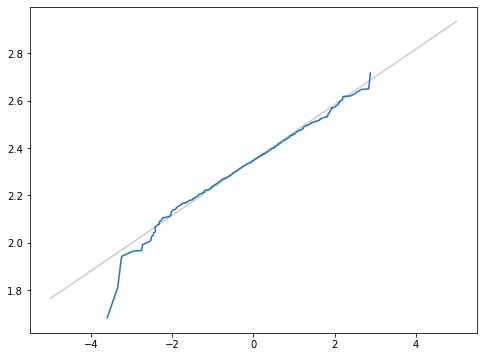

In [545]:
# Solution goes here
aws=[GenerateBirthWeight(birth_weights, n) for _ in range(1000)]
log_aws=np.array(np.log10(aws))

# A normal probability plot and a fit line, data needs to be in array format
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

fit_xs, fit_ys = dsa.FitLine([-5,5], log_aws.mean(), log_aws.std())
xs, ys = dsa.NormalProbabilityValues(log_aws)
ax.plot(fit_xs, fit_ys, color='0.8')
ax.plot(xs, ys)

In [546]:
# Solution goes here

**Exercise:** In Section 14.6 we used the Central Limit Theorem to find the sampling distribution of the difference in means, δ, under the null hypothesis that both samples are drawn from the same population.

We can also use this distribution to find the standard error of the estimate and confidence intervals, but that would only be approximately correct. To be more precise, we should compute the sampling distribution of δ under the alternate hypothesis that the samples are drawn from different populations.

Compute this distribution and use it to calculate the standard error and a 90% confidence interval for the difference in means.

In [547]:
# Solution goes here
# This is the non-parametric way to do this
Ha_results = dsa.ResampleDiffMeans_Ha(firsts.prglngth, others.prglngth)

In [548]:
# Solution goes here
Ha_results

(0.07803726677754952,
 array([ 7.65280941e-02,  1.56618573e-01,  8.54391281e-02,  1.20866041e-01,
         7.71642103e-02,  7.51856555e-02,  1.23579967e-01,  5.70331346e-02,
         5.85304387e-02,  1.01629270e-01,  8.84130142e-02,  5.03288857e-03,
         1.09077361e-01,  1.38615605e-02,  1.01602996e-01,  6.39065103e-02,
         1.74652600e-01,  4.15723344e-02,  3.20006815e-02,  4.93412594e-02,
        -8.77933130e-03,  6.64125456e-02,  9.23650508e-02,  4.67160121e-02,
         8.85714211e-02,  1.02279265e-01,  1.60822481e-01,  3.08802997e-02,
         1.43930133e-03,  6.33651511e-02,  1.98329740e-01,  1.15485662e-01,
         5.87570419e-02,  1.10792176e-01,  2.48047013e-02, -5.06559409e-02,
         4.17908498e-02,  6.71656245e-02,  1.69041598e-01,  1.55652530e-01,
         9.64444352e-02,  5.84170174e-02,  2.54193296e-02,  8.62384368e-02,
         3.83372445e-02,  9.03945839e-02,  1.02740798e-01,  1.13646802e-01,
         7.67223460e-02,  6.39532666e-02,  1.07945111e-01,  1.7871

In [549]:
# Solution goes here
summary_results = dsa.SummarizeEstimates(Ha_results[1])

In [550]:
# Solution goes here
# These results are similar to what is obtained by the author using parametric methods
# The variance is given by summary_results[1]**2 which matches with the author's results
summary_results, summary_results[1]**2

((0.07892901854006731,
  0.05426864640909877,
  (-0.023145496733640414, 0.18564651668739884)),
 0.0029450859830757892)

In [551]:
# Try a parametric version of the same thing
# The standard deviations need to be converted to standard errors first
mean_diff=firsts.prglngth.mean() - others.prglngth.mean()
firsts_std_error = firsts.prglngth.std() / np.sqrt(len(firsts.prglngth))
others_std_error = others.prglngth.std() / np.sqrt(len(others.prglngth))
variance=firsts_std_error**2 + others_std_error**2
mean_diff, variance, firsts.prglngth.std()

(0.07803726677754952, 0.003211435677916389, 2.7919014146686947)

In [576]:
# This gives the same kind of result as the non-parametric method
mean_diff_norm = stats.norm(mean_diff, np.sqrt(variance))
mean_diff_norm.std(), mean_diff_norm.interval(0.95)

(0.05666953041905667, (-0.03303297186459858, 0.18910750541969762))

In [553]:
# Can try the statsmodels compare means method too
import statsmodels.stats.api as sms
cm = sms.CompareMeans(sms.DescrStatsW(firsts.prglngth), sms.DescrStatsW(others.prglngth))
cm.tconfint_diff(usevar='unequal')

(-0.03304794176118778, 0.18912247531628681)

**Exercise:** [In a recent paper](http://ieeexplore.ieee.org/document/7044435/), Stein et al. investigate the effects of an intervention intended to mitigate gender-stereotypical task allocation within student engineering teams.

Before and after the intervention, students responded to a survey that asked them to rate their contribution to each aspect of class projects on a 7-point scale.

Before the intervention, male students reported higher scores for the programming aspect of the project than female students; on average men reported a score of 3.57 with standard error 0.28. Women reported 1.91, on average, with standard error 0.32.

Compute the sampling distribution of the gender gap (the difference in means), and test whether it is statistically significant. Because you are given standard errors for the estimated means, you don’t need to know the sample size to figure out the sampling distributions.

After the intervention, the gender gap was smaller: the average score for men was 3.44 (SE 0.16); the average score for women was 3.18 (SE 0.16). Again, compute the sampling distribution of the gender gap and test it.

Finally, estimate the change in gender gap; what is the sampling distribution of this change, and is it statistically significant?

In [554]:
# Solution goes here
xs=np.linspace(-3,3,101)
ps=stats.norm.cdf(xs)

In [555]:
# Solution goes here
ps

array([0.0013499 , 0.00164106, 0.00198838, 0.00240118, 0.00289007,
       0.00346697, 0.0041453 , 0.00494002, 0.00586774, 0.00694685,
       0.00819754, 0.00964187, 0.01130384, 0.01320938, 0.01538633,
       0.01786442, 0.02067516, 0.02385176, 0.02742895, 0.03144276,
       0.03593032, 0.04092951, 0.04647866, 0.05261614, 0.05937994,
       0.0668072 , 0.0749337 , 0.08379332, 0.09341751, 0.10383468,
       0.11506967, 0.12714315, 0.14007109, 0.15386423, 0.16852761,
       0.18406013, 0.20045419, 0.21769544, 0.2357625 , 0.25462691,
       0.27425312, 0.29459852, 0.3156137 , 0.33724273, 0.35942357,
       0.38208858, 0.40516513, 0.42857628, 0.45224157, 0.47607782,
       0.5       , 0.52392218, 0.54775843, 0.57142372, 0.59483487,
       0.61791142, 0.64057643, 0.66275727, 0.6843863 , 0.70540148,
       0.72574688, 0.74537309, 0.7642375 , 0.78230456, 0.79954581,
       0.81593987, 0.83147239, 0.84613577, 0.85992891, 0.87285685,
       0.88493033, 0.89616532, 0.90658249, 0.91620668, 0.92506

In [556]:
# Solution goes here
# When subtracting normal distributions the means are subtracted but the variances are added
before_gap=3.57-1.91
before_var= 0.28**2 + 0.32**2
before_std=np.sqrt(before_var)
before_rv = stats.norm(before_gap, before_std)
before_std

0.425205832509386

In [557]:
# Solution goes here
# significant
before_rv.mean(), before_rv.cdf(0)

(1.66, 4.730953232082172e-05)

In [558]:
# Solution goes here
after_gap=3.44-3.18
after_var=0.16**2 + 0.16**2
after_std=np.sqrt(after_var)
after_rv=stats.norm(after_gap, after_std)
after_std

0.2262741699796952

In [559]:
# after the intervention it is no longer significant
after_rv.mean(), after_rv.cdf(0)

(0.2599999999999998, 0.12526798720681914)

Try making sampling distribution for difference of means. See if the p-value obtained using the null hypothesis sampling distribution equal the p-value for the difference of means sampling distribution

In [560]:
mean_diff = firsts.prglngth.mean() - others.prglngth.mean()
mean_diff

0.07803726677754952

In [561]:
# Try with current resample function, should actually be for the null hypothesis so cannot get the confidence interval
diff_list = dsa.ResampleDiffMeans_H0(firsts.prglngth, others.prglngth, onesided=True)

In [562]:
diff_list = np.array(diff_list[1])
diff_list.mean()

0.002546272065996668

In [563]:
# P-value using the null hypothesis sampling distribution and the actual difference
dsa.PvalueFromEstimates(diff_list, mean_diff, tail='right')

0.0899999999999993

In [564]:
def DiffMeansSampleDist(a,b,iters=1000):
    a=pd.Series(a)
    b=pd.Series(b)
    
    resample_dist = []
    for _ in range(iters):
        a_resample = a.sample(n=len(a), replace=True)
        b_resample = b.sample(n=len(b), replace=True)
        resample_diff = np.mean(a_resample) - np.mean(b_resample)
        resample_dist.append(resample_diff)
    
    return np.array(resample_dist)

In [565]:
firsts_sample = firsts.prglngth.sample(n=len(firsts.prglngth), replace=True)

In [566]:
others_sample = others.prglngth.sample(n=len(others.prglngth), replace=True)

In [567]:
sample_diff = firsts_sample.mean() - others_sample.mean()
sample_diff

0.15550096659313795

In [568]:
resample_dist = DiffMeansSampleDist(firsts.prglngth, others.prglngth)
resample_dist.mean()

0.07882990004333454

In [569]:
results = dsa.SummarizeEstimates(resample_dist)
results

(0.07882990004333454,
 0.05752740691597031,
 (-0.031172610634172315, 0.1903518714865413))

In [570]:
# The p-value at zero from using the sampling distribution of the difference of the means
# is very close to the value obtained using the null hypothesis sampling distribution at the actual difference of the means
dsa.PvalueFromEstimates(resample_dist, 0)

0.9169999999999999

In [571]:
def ResampleDiffMeans_Ha(a, b, iters=1000):
    """Generates a difference in means sampling distribution for the alternative hypothesis that two groups differ via resampling of each group. 
    In this case the resampling is done on each sample separately. 
    (ie. assuming the alternative hypothesis that the samples are different)
    Can then make an rv of this distribution to calculate sample distribution mean, std deviation (std error), and confidence interval (rv.interval). 
    If a p-value needs to be calculated use the the H0 version of this function.

    Args:
        a (array-like): Input data set 1
        b (array-like): Input data set 2
        iters (int, optional): The number of simulations to run (Defaults to 1000)
        
    Returns:
        test_diff: Original actual difference in means value
        diff_mean_results (array): Sampling distribution for the alternative hypothesis obtained from resampling
    """
    a=pd.Series(a)
    b=pd.Series(b)
    
    diff_mean_results = []
    
    test_diff = a.mean() - b.mean() # The test stat if onesided
    
    for _ in range(iters):
        a_resample = a.sample(n=len(a), replace=True)
        b_resample = b.sample(n=len(b), replace=True)
        resample_diff = a_resample.mean() - b_resample.mean()
        diff_mean_results.append(resample_diff)
        
    return test_diff, np.array(diff_mean_results)

In [572]:
results = ResampleDiffMeans_Ha(firsts.prglngth, others.prglngth)
results[0], results[1].mean()

(0.07803726677754952, 0.08183000968387781)

In [573]:
HaRv = dsa.DiscreteRv(results[1])

In [574]:
HaRv.interval(0.95)

(-0.025233692045993905, 0.18815078135038732)